# Data Processing Classes and Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft, fftfreq
from pydub import AudioSegment
import matplotlib
from pydub.playback import play
from collections import deque 

In [2]:
class Analyzer:

    def __init__(self, file_path,source='Sound_Files/'):
        self.audio = AudioSegment.from_wav(source+file_path)
        self.file_name = file_path
        self.SAMPLE_RATE, self.data = wav.read(source+file_path)
        self.DURATION = len(self.audio)/1000
        self.xf, self.stft_out = None, None

    def play_file(self):
        return self.audio

    def split_audio(self, k=1):

        s = np.round(len(self.audio)/k)
        return [self.audio[i*s:(i+1)*s] for i in range(k)]
        # return np.split(self.audio,k)

    def get_data(self):
        return self.data

    def fft(self):
        clip_duration = 0.5
        end_index = int(np.rint(self.data.shape[0] * (clip_duration / self.DURATION))) # 1st 500 ms of audio
        clip_data = self.data[:end_index]

        duration = clip_duration
        # N = self.SAMPLE_RATE * self.DURATION
        N = int(self.SAMPLE_RATE * duration)

        self.xf = fftfreq(N, 1 / self.SAMPLE_RATE)
        return self.xf,fft(clip_data)

    def plot(self, l, r,save_path,k=1,lim=1,rows=1,my_top=0.9):
        cols = int(k/rows)
        fig, axs = plt.subplots(rows,cols,figsize=(20,3*rows))
        cur_data, cur_out = self.stft(k)
        fig.suptitle('File ' + self.file_name)
        fig.subplots_adjust(top=my_top)
        if lim > len(cur_out):
            lim = len(cur_out)
        cur_out = cur_out[:lim]
        for i in range(lim):
            x = int(i/cols)
            y = i%cols
            if k == 1:
                cur_ax = axs
            else:
                if rows == 1:
                    cur_ax = axs[y]
                else:
                    cur_ax = axs[x,y]
            cur_ax.title.set_text('Split ' + str(i+1))
            cur_ax.plot(cur_data,np.abs(cur_out[i]))

            cur_ax.set_ylim(0,2e7)
            cur_ax.set_xlim(l,r)
        if k==1:
            axs.set(xlabel='Frequencies', ylabel='Amplitudes')
        else:
            for ax in axs.flat:
                ax.set(xlabel='Frequencies', ylabel='Amplitudes')

            # Hide x labels and tick labels for top plots and y ticks for right plots.
            for ax in axs.flat:
                ax.label_outer()

        fig.subplots_adjust(hspace=.2)
        plt.savefig('STFT_Graphs/' + save_path)


        plt.show()

In [3]:
def filter_signal(old_x,old_y):
    # Filter frequencies 0-5000
    l = -1
    r = -1
    for i in range(len(old_x)):
        if old_x[i] >= 0 and l == -1:
            l = i
        if old_x[i] > 5000 and r == -1:
            r = i
    x = old_x[l:r]
    y = old_y[l:r]
    
    # Find local maxima
    local_maxima_x = []
    local_maxima_y = []
    HALFWAY_NOTE_DOWN_RATIO = 2 ** (1/24) # sqrt of the ratio of the freq of any note to one note lower
    queue = deque([0]) 
    maxima_flags = [False] * x.shape[0]
    cur_index = 1
    while cur_index < x.shape[0]:
        if y[cur_index] >= y[queue[0]]:
            # clear queue only if new potential maxima found
            queue.clear()
            maxima_flags[cur_index] = True        
        queue.append(cur_index)
            
        # if value in queue moves out of the range, check if maxima and then remove
        if queue[0] <= cur_index / HALFWAY_NOTE_DOWN_RATIO:
            if maxima_flags[queue[0]]:
                local_maxima_x.append(x[queue[0]])
                local_maxima_y.append(y[queue[0]])
            queue.popleft()
        cur_index += 1
    
    # pick out highest amplitude frequencies
    stacked_data = np.stack((local_maxima_x,local_maxima_y))
    sorted_stacked_data = stacked_data[:,np.flip(stacked_data[1,:].argsort())]
    extracted_data = sorted_stacked_data[:,:NUM_FREQS]
    data_resorted_by_freq = extracted_data[:,extracted_data[0,:].argsort()]
    
    return  data_resorted_by_freq[0], data_resorted_by_freq[1]

In [4]:
matplotlib.rcParams.update({'font.size': 12})

# Model and Optimization Helper Functions

In [5]:
from scipy.special import logsumexp

In [6]:
# returns z as an array in base 3
def compute_v(z):
    v = np.base_repr(z,base=3).zfill(NUM_FREQS)
    return np.array([int(j) for j in list(v)])

# returns corresponding disallowed latent
def compute_disallowed_z(z):
    v = compute_v(z)
    disallowed_latent = 0
    base_component = 3 ** NUM_FREQS
    for i in range(NUM_FREQS):
        base_component /= 3
        if v[i] == 2:
            disallowed_latent += 2 * base_component
        else:
            disallowed_latent += (1 - v[i]) * base_component
    #
    return disallowed_latent
    
# checks if latent is allowed
def check_latent(z):
    if z not in disallowed_latents:
        # check if there is at least one 0 and one 1
        v = compute_v(z)
        return np.count_nonzero(v == 1) >= 1 and np.count_nonzero(v == 0) >= 1
    return False

In [7]:
# returns array of counts of j values seen in v by index i
def compute_counts(v,j):
    counts = []
    cur_count = 0
    for i in range(len(v)):
        cur_count += int(v[i] == j)
        counts.append(cur_count)
    return np.array(counts)

# returns sum(f_{ni} - Fo_{nj} * C_{nji}) over all (i, v[i] != 2) for given n,v
def compute_sum_normal_exp_over_i(n,z):
    v = compute_v(z)
    counts = [compute_counts(v,j) for j in range(2)]
    sum = 0
    for i in range(NUM_FREQS):
        if v[i] != 2:
            count = counts[v[i]][i]
            sum += (data[n,i] - fo_params[n,LATENTS[z],v[i]] * count) ** 2
    return sum
    

# computes likelihoods exponents for data point n over all z
# returns array of exponents
def compute_likelihood_exponents(n):
    exponents = []
    for z in LATENTS:
        sum = -1/(2*variance) * compute_sum_normal_exp_over_i(n,z)
        exponents.append(sum)
    return np.array(exponents)
        

# computes component responsibilities for data point n over all z
# returns array of r values
def compute_r(n):
    exponents = compute_likelihood_exponents(n)
    r_n = []
    for z in LATENTS:
        log_numerator = logsumexp([exponents[LATENTS[z]]],b=[pi_params[LATENTS[z]]])
        log_denom = logsumexp(exponents,b=pi_params)
        r_n.append(np.exp(log_numerator - log_denom))
    #
    return np.array(r_n)

# computes Fo updates for data point n
# returns array of shape (len(LATENTS),2)
def compute_Fo_updates(n,r_values):
    updated_Fo = []
    for z in LATENTS:
        Fo_pair = []
        for j in range(2):
            v = compute_v(z)
            
            i_selector = (v == j)
            selected_counts = compute_counts(v,j)
            sum_fs = np.dot(i_selector,data[n])
            sum_Cs = np.dot(i_selector, selected_counts)
            
            Fo_pair.append(sum_fs / sum_Cs)
        #    
        updated_Fo.append(Fo_pair)
    #
    return np.array(updated_Fo)

# computes and returns updated variance
# default alpha/beta values give no prior
def compute_variance_update(r_values,alpha=-1,beta=0):
    total_sum_num = 0
    total_sum_denom = 0
    for n in range(N):
        for z in LATENTS:
            sum_num = compute_sum_normal_exp_over_i(n,z)
            total_sum_num += r_values[n,LATENTS[z]] * sum_num
            
            v = compute_v(z)
            total_sum_denom += r_values[n,LATENTS[z]] * np.sum(v != 2)
        #
    #
    total_sum_num = 1/2 * total_sum_num + beta
    denom = 1/2 * N * NUM_FREQS + (alpha + 1)
    
    return total_sum_num / denom

# Evaluation Helper Methods

In [8]:
# piano key frequency formula that takes a frequency value and outputs the closest note number
def freq_to_note_num(freq):
    return np.rint(12 * np.log2(freq / 440) + 49).astype(np.int32)

# returns note name give piano key number
def note_num_to_name(note_num):
    note_mapper = {
        0: 'C',
        1: 'C#',
        2: 'D',
        3: 'D#',
        4: 'E',
        5: 'F',
        6: 'F#',
        7: 'G',
        8: 'G#',
        9: 'A',
        10: 'A#',
        11: 'B',
    }
    
    note = note_mapper[(note_num - 4) % 12]
    octave_num = (note_num + 8) // 12
    return note + str(octave_num)

# inverse of above
def note_name_to_num(note_name):
    reverse_note_mapper = {
        'C': 0,
        'C#': 1,
        'D': 2,
        'D#': 3,
        'E': 4,
        'F': 5,
        'F#': 6,
        'G': 7,
        'G#': 8,
        'A': 9,
        'A#': 10,
        'B': 11,
    }
    
    note = note_name[:-1]
    octave_num = int(note_name[-1])
    return (octave_num-1) * 12 + (reverse_note_mapper[note] + 4)

# takes label strings and converts them to note nums
# returns array
def convert_label_strings_to_note_nums(label_strings):
    return np.array([list(map(note_name_to_num,note_name_pair)) for note_name_pair in label_strings])

# takes the predicted fo values and converts them to the nearest note name
# returns list of sets
def convert_pred_fo_to_notes(fo_found):
    note_nums = freq_to_note_num(fo_found)
    return [set(map(note_num_to_name,note_name_pair)) for note_name_pair in note_nums.tolist()]

# computes chord accuracy
def compute_chord_accuracy(predicted_labels):
    error_count = 0
    for i in range(N):
        pred_freqs = predicted_labels[i]
        label_set = label_strings[i]
        
        for fo in label_set:
            if fo not in pred_freqs:
                error_count += 1
                break
        #
    #
    return 1 - error_count / N

# determines accuracy by individual notes
def compute_overall_note_accuracy(predicted_labels):
    error_count = 0
    for i in range(N):
        pred_freqs = predicted_labels[i]
        label_set = label_strings[i]
        
        for fo in label_set:
            if fo not in pred_freqs:
                error_count += 1
        #
    #
    return 1 - error_count / (N*2)

def compute_mean_absolute_error(fo_found):
    pred_note_nums = np.sort(freq_to_note_num(fo_found))
    label_note_nums = np.sort(convert_label_strings_to_note_nums(label_strings))
    
    return np.mean(np.abs(pred_note_nums - label_note_nums))

# Data Processing

['Sound_Files/C_Seventh_Octave\\C7A6.wav', 'Sound_Files/C_Seventh_Octave\\C7B6.wav', 'Sound_Files/C_Seventh_Octave\\C7D7.wav', 'Sound_Files/C_Seventh_Octave\\C7E7.wav', 'Sound_Files/C_Seventh_Octave\\C7F7.wav', 'Sound_Files/C_Seventh_Octave\\C7G7.wav']


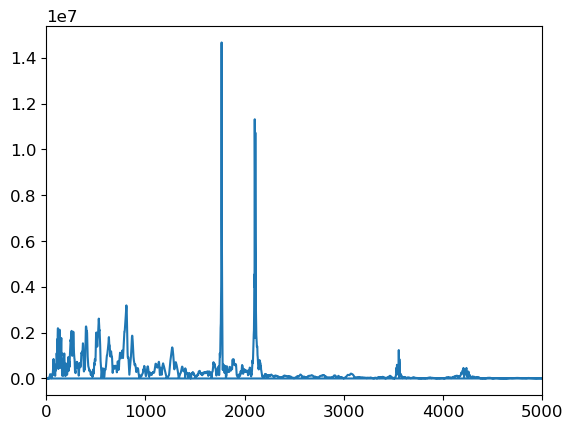

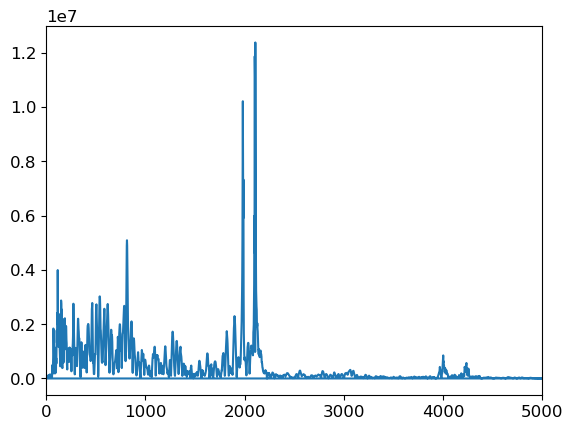

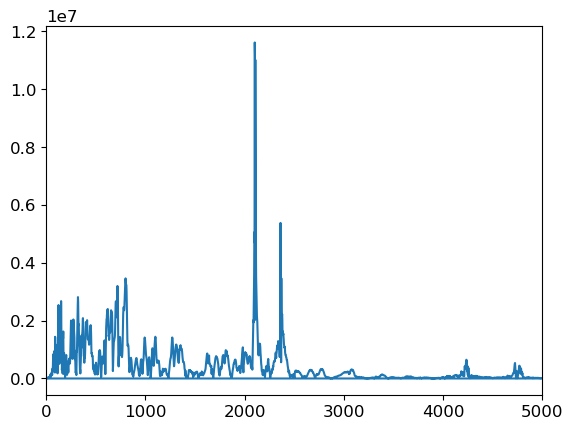

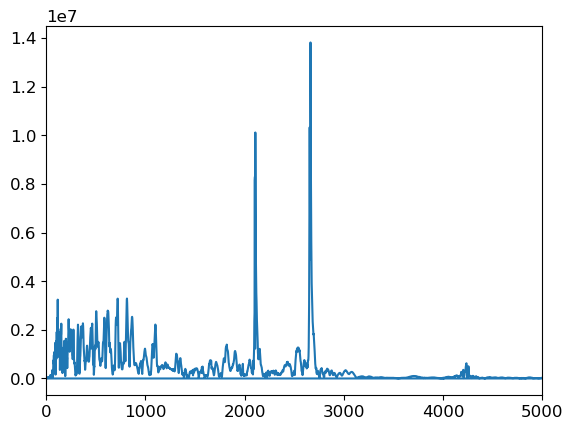

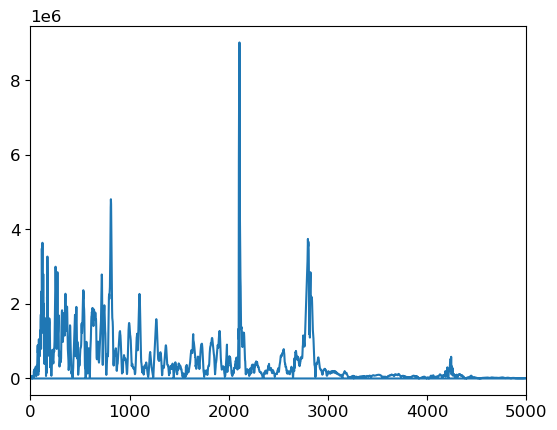

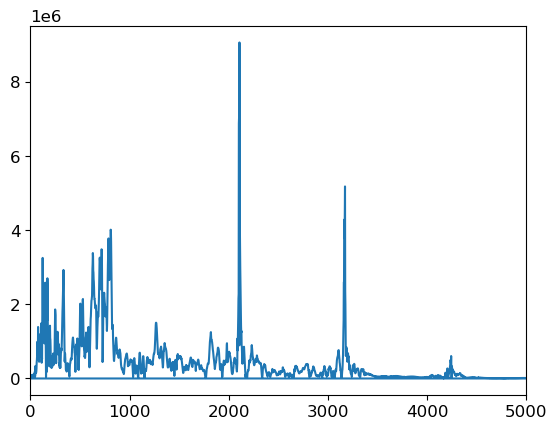

In [412]:
NUM_FREQS = 8
import glob
sources = [
    #"Sound_Files/C_Third_Octave/",
    #"Sound_Files/C_Fourth_Octave/",
    #"Sound_Files/C_Fifth_Octave/",
    "Sound_Files/C_Seventh_Octave/",
]

filenames = []
for octave_path in sources:
    filenames.extend(glob.glob(octave_path + "*"))
print(filenames)

data = []
label_strings = []
for sound_file in filenames:
    filename = sound_file[12:]
    test = Analyzer(filename)

    x_fft, fft_arr = test.fft()
    plt.plot(x_fft,np.abs(fft_arr))
    plt.xlim(0,5000)
    plt.show()

    freqs, amplitudes = filter_signal(x_fft,np.abs(fft_arr))
    data.append(freqs)
    #print(freqs)

    #plt.scatter(freqs,amplitudes)
    #plt.show()
    
    labels = set([filename[-8:-6], filename[-6:-4]])
    label_strings.append(labels)
#
data = np.array(data)
#print(data)
#print(label_strings)

# Model and Optimization

In [402]:
# constants
N = data.shape[0]
num_iter = 10
var_ALPHA=1
var_BETA=2
pi_importance_ratio = .8

# construct the latent space
LATENTS = {}
disallowed_latents = set()

z_index = 0
for z in range(1,3 ** NUM_FREQS-1):
    if check_latent(z):
        LATENTS[z] = z_index
        disallowed_latents.add(compute_disallowed_z(z))
        z_index += 1

In [403]:
# parameter initializations
variance = 2 # just testing a large number
fo_params = np.full((N,len(LATENTS),2),np.array([5000/3,5000*2/3])) # split the 0-5000 range

# compute pi initializations
#pi_params = np.full((len(LATENTS)), 1/(len(LATENTS)))
count_2s_lst = []
num_2_counts = np.zeros(NUM_FREQS-1)
for z in LATENTS:
    v = compute_v(z)
    count_2s_in_v = np.count_nonzero(v == 2)
    count_2s_lst.append(count_2s_in_v)
    num_2_counts[count_2s_in_v] += 1
    
pi_for_no_2s = 1 / np.dot(num_2_counts,np.geomspace(1, pi_importance_ratio ** (NUM_FREQS-2), num=NUM_FREQS-1))
pi_params = pi_for_no_2s * np.power(pi_importance_ratio, np.array(count_2s_lst))

In [404]:
# Expectation Maximization
for _ in range(num_iter):
    # E-Step
    r_values = np.array([compute_r(n) for n in range(N)])
    
    # keeping pi_params constant
    
    # M-Step: update Fo params
    fo_params = np.array([compute_Fo_updates(n,r_values) for n in range(N)])
    
    # update variance
    variance = compute_variance_update(r_values,var_ALPHA,var_BETA)

In [405]:
# check params
indices = np.argmax(r_values,axis=1)
fo_found = fo_params[np.arange(N),indices]
r_chosen_responsibility = r_values[np.arange(N),indices].reshape(-1,1)

#print(np.sqrt(variance))
#print(fo_found)
#print(r_chosen_responsibility)
#print(indices)

# Evaluation

In [406]:
predicted_labels = convert_pred_fo_to_notes(fo_found)
chord_accuracy = compute_chord_accuracy(predicted_labels)
note_accuracy = compute_overall_note_accuracy(predicted_labels)
mean_abs_error = compute_mean_absolute_error(fo_found)
print(chord_accuracy)
print(note_accuracy)
print(mean_abs_error)

0.38888888888888884
0.6944444444444444
3.361111111111111


In [407]:
print(convert_pred_fo_to_notes(fo_found))
print(label_strings)

[{'C4', 'A2'}, {'C4', 'B2'}, {'C4', 'C3'}, {'C4', 'E3'}, {'C4', 'F3'}, {'C4', 'G3'}, {'C4', 'A3'}, {'B3', 'C4'}, {'C4', 'D5'}, {'C4', 'E4'}, {'C4', 'F4'}, {'C4', 'E2'}, {'A4', 'C5'}, {'B4', 'C5'}, {'D5', 'C5'}, {'D5', 'C5'}, {'C#5', 'C5'}, {'C#5', 'C5'}]
[{'A2', 'C3'}, {'B2', 'C3'}, {'D3', 'C3'}, {'E3', 'C3'}, {'F3', 'C3'}, {'G3', 'C3'}, {'C4', 'A3'}, {'C4', 'B3'}, {'C4', 'D4'}, {'C4', 'E4'}, {'C4', 'F4'}, {'C4', 'G4'}, {'A4', 'C5'}, {'B4', 'C5'}, {'D5', 'C5'}, {'E5', 'C5'}, {'F5', 'C5'}, {'G5', 'C5'}]
